In [64]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Train on these
normal_market_path = "training_data_normal_market.parquet"
stressed_market_path = "training_data_stressed_market.parquet"
hft_dominated_path = "training_data_hft_dominated.parquet"

# Just to visualize
mini_flash_crash_path = "training_data_mini_flash_crash.parquet"
flash_crash_path = "training_data_flash_crash.parquet"

# Master file
master_path = "master_training_data.parquet"

In [65]:
# Concatting the files that we will actually train on
files = [
    normal_market_path,
    stressed_market_path,
    hft_dominated_path,
]

df = pd.read_parquet(master_path)
df = df[~df['scenario'].str.contains("crash", case=False)].copy()
print(df.head(n=100))

    step    bid     ask     mid  spread       scenario     timestamp
0      0    0.0     0.0    0.00     0.0  normal_market  1.768680e+09
1      1  999.9  1000.0  999.95     0.1  normal_market  1.768680e+09
2      2  999.9  1000.0  999.95     0.1  normal_market  1.768680e+09
3      3  999.8  1000.0  999.90     0.2  normal_market  1.768680e+09
4      4  999.8   999.9  999.85     0.1  normal_market  1.768680e+09
..   ...    ...     ...     ...     ...            ...           ...
95    95  999.8   999.9  999.85     0.1  normal_market  1.768680e+09
96    96  999.8   999.9  999.85     0.1  normal_market  1.768680e+09
97    97  999.8   999.9  999.85     0.1  normal_market  1.768680e+09
98    98  999.8   999.9  999.85     0.1  normal_market  1.768680e+09
99    99  999.8   999.9  999.85     0.1  normal_market  1.768680e+09

[100 rows x 7 columns]


### Visualizing the data

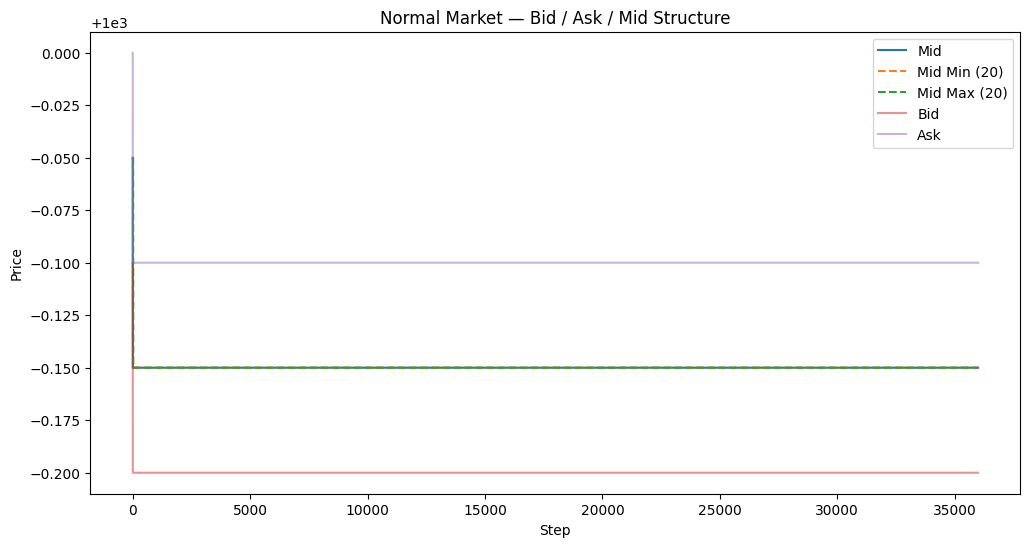

In [49]:
normal_market_df = pd.read_parquet(normal_market_path)

normal_market_df = normal_market_df.iloc[1:]

window = 20  # short-term structure

normal_market_df["bid_min"] = normal_market_df["bid"].rolling(window).min()
normal_market_df["bid_max"] = normal_market_df["bid"].rolling(window).max()

normal_market_df["ask_min"] = normal_market_df["ask"].rolling(window).min()
normal_market_df["ask_max"] = normal_market_df["ask"].rolling(window).max()

normal_market_df["mid_min"] = normal_market_df["mid"].rolling(window).min()
normal_market_df["mid_max"] = normal_market_df["mid"].rolling(window).max()

plt.figure(figsize=(12, 6))

plt.plot(normal_market_df["step"], normal_market_df["mid"], label="Mid")
plt.plot(normal_market_df["step"], normal_market_df["mid_min"], linestyle="--", label="Mid Min (20)")
plt.plot(normal_market_df["step"], normal_market_df["mid_max"], linestyle="--", label="Mid Max (20)")

plt.plot(normal_market_df["step"], normal_market_df["bid"], alpha=0.5, label="Bid")
plt.plot(normal_market_df["step"], normal_market_df["ask"], alpha=0.5, label="Ask")

plt.xlabel("Step")
plt.ylabel("Price")
plt.title("Normal Market — Bid / Ask / Mid Structure")
plt.legend()
plt.show()


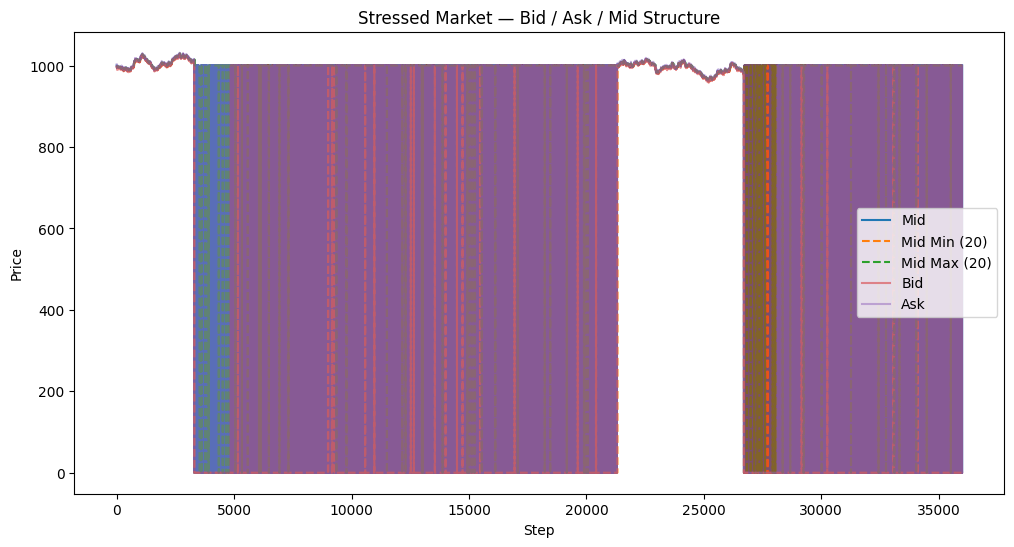

   step    bid     ask      mid  spread         scenario     timestamp  \
1     1  997.0  1003.0  1000.00     6.0  stressed_market  1.768680e+09   
2     2  997.4  1000.0   998.70     2.6  stressed_market  1.768680e+09   
3     3  996.8   998.7   997.75     1.9  stressed_market  1.768680e+09   
4     4  997.6   997.9   997.75     0.3  stressed_market  1.768680e+09   
5     5  997.6   997.9   997.75     0.3  stressed_market  1.768680e+09   

   bid_min  bid_max  ask_min  ask_max  mid_min  mid_max  
1      NaN      NaN      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN      NaN      NaN  
5      NaN      NaN      NaN      NaN      NaN      NaN  


In [50]:
stressed_market_df = pd.read_parquet(stressed_market_path)

#stressed_market_df = stressed_market_df[(stressed_market_df["bid"] > 0) & (stressed_market_df["ask"] > 0) & (stressed_market_df["mid"] > 0)]
stressed_market_df = stressed_market_df.iloc[1:].reset_index(drop=True)

window = 20  # short-term structure

stressed_market_df["bid_min"] = stressed_market_df["bid"].rolling(window).min()
stressed_market_df["bid_max"] = stressed_market_df["bid"].rolling(window).max()

stressed_market_df["ask_min"] = stressed_market_df["ask"].rolling(window).min()
stressed_market_df["ask_max"] = stressed_market_df["ask"].rolling(window).max()

stressed_market_df["mid_min"] = stressed_market_df["mid"].rolling(window).min()
stressed_market_df["mid_max"] = stressed_market_df["mid"].rolling(window).max()

plt.figure(figsize=(12, 6))

plt.plot(stressed_market_df["step"], stressed_market_df["mid"], label="Mid")
plt.plot(stressed_market_df["step"], stressed_market_df["mid_min"], linestyle="--", label="Mid Min (20)")
plt.plot(stressed_market_df["step"], stressed_market_df["mid_max"], linestyle="--", label="Mid Max (20)")

plt.plot(stressed_market_df["step"], stressed_market_df["bid"], alpha=0.5, label="Bid")
plt.plot(stressed_market_df["step"], stressed_market_df["ask"], alpha=0.5, label="Ask")

plt.xlabel("Step")
plt.ylabel("Price")
plt.title("Stressed Market — Bid / Ask / Mid Structure")
plt.legend()
plt.show()
print(stressed_market_df.head(5))

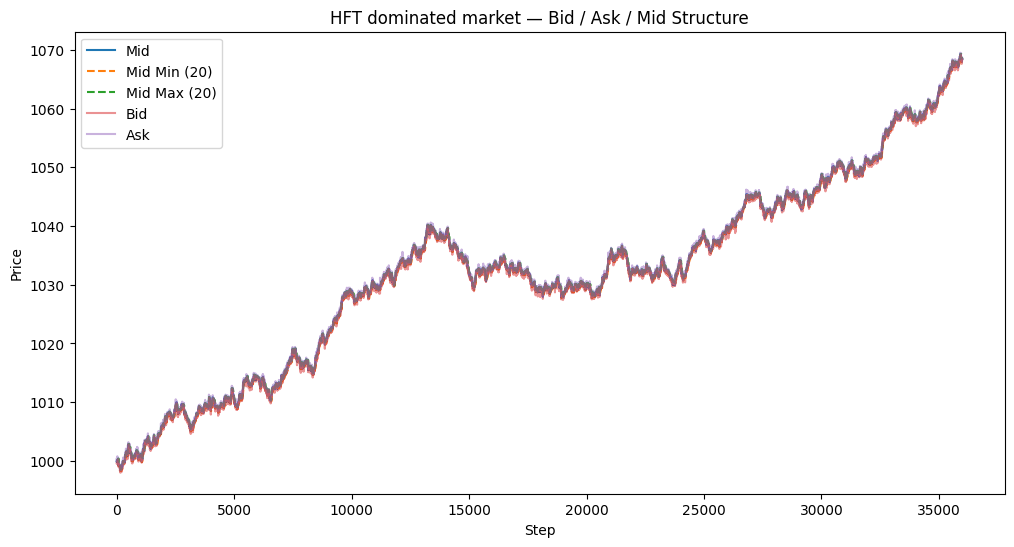

In [63]:
hft_dominated_df = pd.read_parquet(hft_dominated_path)

hft_dominated_df = hft_dominated_df.iloc[1:].reset_index(drop=True)

window = 20  # short-term structure

hft_dominated_df["bid_min"] = hft_dominated_df["bid"].rolling(window).min()
hft_dominated_df["bid_max"] = hft_dominated_df["bid"].rolling(window).max()

hft_dominated_df["ask_min"] = hft_dominated_df["ask"].rolling(window).min()
hft_dominated_df["ask_max"] = hft_dominated_df["ask"].rolling(window).max()

hft_dominated_df["mid_min"] = hft_dominated_df["mid"].rolling(window).min()
hft_dominated_df["mid_max"] = hft_dominated_df["mid"].rolling(window).max()

plt.figure(figsize=(12, 6))

plt.plot(hft_dominated_df["step"], hft_dominated_df["mid"], label="Mid")
plt.plot(hft_dominated_df["step"], hft_dominated_df["mid_min"], linestyle="--", label="Mid Min (20)")
plt.plot(hft_dominated_df["step"], hft_dominated_df["mid_max"], linestyle="--", label="Mid Max (20)")

plt.plot(hft_dominated_df["step"], hft_dominated_df["bid"], alpha=0.5, label="Bid")
plt.plot(hft_dominated_df["step"], hft_dominated_df["ask"], alpha=0.5, label="Ask")

plt.xlabel("Step")
plt.ylabel("Price")
plt.title("HFT dominated market — Bid / Ask / Mid Structure")
plt.legend()
plt.show()

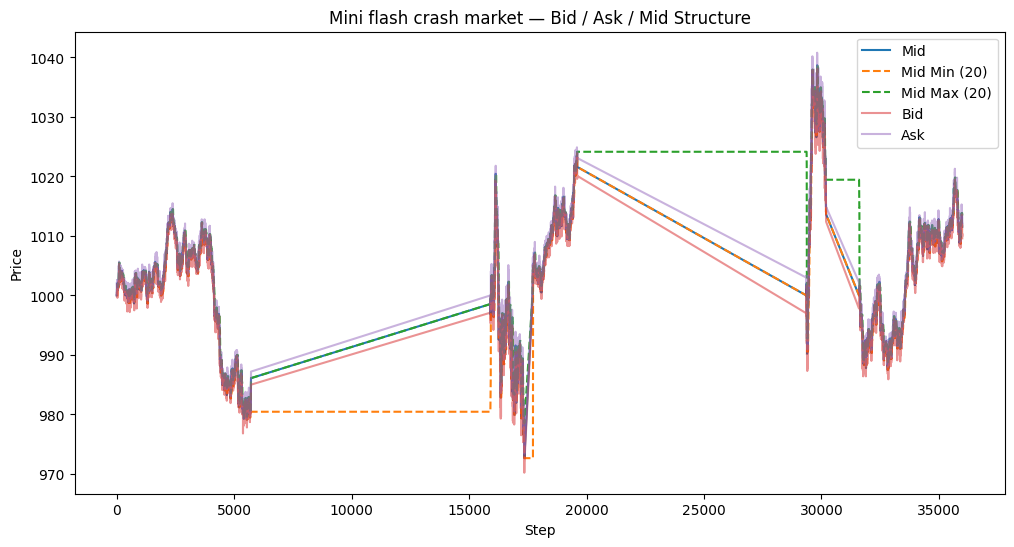

In [59]:
mini_flash_crash_df = pd.read_parquet(mini_flash_crash_path)

mini_flash_crash_df = mini_flash_crash_df[(mini_flash_crash_df["bid"] > 0) & (mini_flash_crash_df["ask"] > 0) & (mini_flash_crash_df["mid"] > 0)]
#mini_flash_crash_df = mini_flash_crash_df.iloc[1:].reset_index(drop=True)

window = 20  # short-term structure

mini_flash_crash_df["bid_min"] = mini_flash_crash_df["bid"].rolling(window).min()
mini_flash_crash_df["bid_max"] = mini_flash_crash_df["bid"].rolling(window).max()

mini_flash_crash_df["ask_min"] = mini_flash_crash_df["ask"].rolling(window).min()
mini_flash_crash_df["ask_max"] = mini_flash_crash_df["ask"].rolling(window).max()

mini_flash_crash_df["mid_min"] = mini_flash_crash_df["mid"].rolling(window).min()
mini_flash_crash_df["mid_max"] = mini_flash_crash_df["mid"].rolling(window).max()

plt.figure(figsize=(12, 6))

plt.plot(mini_flash_crash_df["step"], mini_flash_crash_df["mid"], label="Mid")
plt.plot(mini_flash_crash_df["step"], mini_flash_crash_df["mid_min"], linestyle="--", label="Mid Min (20)")
plt.plot(mini_flash_crash_df["step"], mini_flash_crash_df["mid_max"], linestyle="--", label="Mid Max (20)")

plt.plot(mini_flash_crash_df["step"], mini_flash_crash_df["bid"], alpha=0.5, label="Bid")
plt.plot(mini_flash_crash_df["step"], mini_flash_crash_df["ask"], alpha=0.5, label="Ask")

plt.xlabel("Step")
plt.ylabel("Price")
plt.title("Mini flash crash market — Bid / Ask / Mid Structure")
plt.legend()
plt.show()

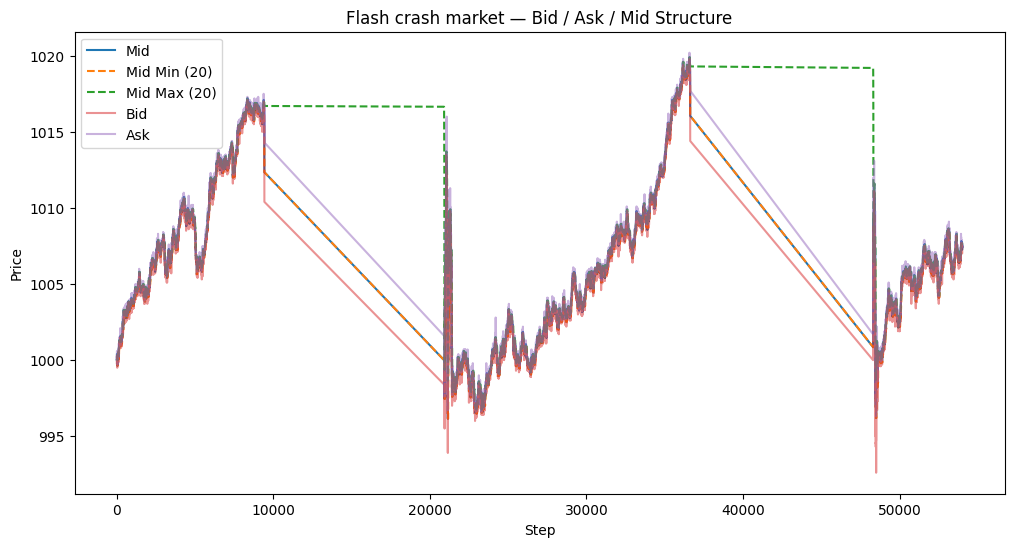

In [61]:
flash_crash_df = pd.read_parquet(flash_crash_path)

flash_crash_df = flash_crash_df[(flash_crash_df["bid"] > 0) & (flash_crash_df["ask"] > 0) & (flash_crash_df["mid"] > 0)]
# flash_crash_df = flash_crash_df.iloc[1:].reset_index(drop=True)

window = 20  # short-term structure

flash_crash_df["bid_min"] = flash_crash_df["bid"].rolling(window).min()
flash_crash_df["bid_max"] = flash_crash_df["bid"].rolling(window).max()

flash_crash_df["ask_min"] = flash_crash_df["ask"].rolling(window).min()
flash_crash_df["ask_max"] = flash_crash_df["ask"].rolling(window).max()

flash_crash_df["mid_min"] = flash_crash_df["mid"].rolling(window).min()
flash_crash_df["mid_max"] = flash_crash_df["mid"].rolling(window).max()

plt.figure(figsize=(12, 6))

plt.plot(flash_crash_df["step"], flash_crash_df["mid"], label="Mid")
plt.plot(flash_crash_df["step"], flash_crash_df["mid_min"], linestyle="--", label="Mid Min (20)")
plt.plot(flash_crash_df["step"], flash_crash_df["mid_max"], linestyle="--", label="Mid Max (20)")

plt.plot(flash_crash_df["step"], flash_crash_df["bid"], alpha=0.5, label="Bid")
plt.plot(flash_crash_df["step"], flash_crash_df["ask"], alpha=0.5, label="Ask")

plt.xlabel("Step")
plt.ylabel("Price")
plt.title("Flash crash market — Bid / Ask / Mid Structure")
plt.legend()
plt.show()

In [66]:
# Remove invalid rows
df = df[(df["bid"] > 0) & (df["ask"] > 0) & (df["mid"] > 0)]

# Encode labels
le = LabelEncoder()
df["y"] = le.fit_transform(df["scenario"])

# Build X and y
X = df.drop(columns=["scenario", "y", "timestamp", "step"])
y = df["y"]

print(dict(zip(le.classes_, le.transform(le.classes_))))

{'hft_dominated': np.int64(0), 'normal_market': np.int64(1), 'stressed_market': np.int64(2)}


In [67]:
# XGBoost 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=3
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

# model.save_model("market_classifier.pkl")

                 precision    recall  f1-score   support

  hft_dominated       0.96      0.99      0.97      9000
  normal_market       1.00      1.00      1.00      9000
stressed_market       0.99      0.96      0.97      9000

       accuracy                           0.98     27000
      macro avg       0.98      0.98      0.98     27000
   weighted avg       0.98      0.98      0.98     27000

